# Figure 12
Plots for future devil population with vaccination + culling interventions

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../GillesPy2')))

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,mark_inset)

In [3]:
from gillespy2 import TauHybridCSolver

In [4]:
from dask.distributed import Client
from dask import delayed

In [5]:
sys.path.insert(2, os.path.abspath(os.path.join(os.getcwd(), './ParameterSweeps')))
from Devils_DFTD_2_Stage_Infection import DevilsDFTD2StageInfection
from Simulation import Simulation, devil_pop
from ParameterSweep import ParameterSweep

In [6]:
c = Client(n_workers=8, threads_per_worker=1)
# c = Client("james.cs.unca.edu:12345")

In [7]:
dates = []
year = 1985
while len(dates) < 1001:
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

## Load Simulation

In [8]:
def get_params(key):
    params = [param.split(":") for param in key.split(",")]
    return {param[0]: float(param[1]) for param in params}

In [9]:
def load_simulation(data_path, key):
    if os.path.exists(data_path):
        with open(data_path, "rb") as data_file:
            sim = pickle.load(data_file)
        return Simulation.load_state(sim)
    
    data_path = "./ParameterSweeps/DevilsDFTD2StageInfectionWithVaccinationAndCullingState.p"
    if os.path.exists(data_path):
        try:
            with open(data_path, "rb") as state_file:
                sim = pickle.load(state_file)['job'].results[key]
            return Simulation.load_state(sim)
        except Exception as err:
            raise Exception("Parameter Data is not currently available.") from err
    
    model = DevilsDFTD2StageInfection(devil_pop, interventions="vaccination")
    
    sol = delayed(TauHybridCSolver)(model=model, variable=True)
    
    params = get_params(key)
    
    sim = Simulation(model, variables=params)
    sim.configure(solver=sol)
    return sim

In [10]:
def plot_figure(sim, start=0, alpha=0.3, plot_observed=False, plot_immunity_level=True, save_fig=None):
    carry_cap = int(max(devil_pop)*1.16)
    dftd_start = int(sim.result[0].model.listOfParameters['DFTD_introduction'].value)

    x = sim.result[0]['time'][start:]
    text_offset = (sim.result[0]['time'].size - start) / 601

    fig, ax1 = plt.subplots(figsize=[15, 8])
    title = f"Tasmanian Devil Population with DFTD and Vaccination Intervention"
    plt.title(title, fontsize=18)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=14)

    for i, result in enumerate(sim.result):
        spec_list = [sim.result[i]['Juvenile'], sim.result[i]['Susceptible'], sim.result[i]['Exposed'],
                 sim.result[i]['Infected'], sim.result[i]['Diseased'], sim.result[i]['Vaccinated']]
        total_devils = np.add.reduce(spec_list)
        if i == 0:
            ax1.plot(x, total_devils[start:], color='blue', label='Total Devils')
            ax1.plot(x, sim.result[i]['Juvenile'][start:], color='purple', label='Juvenile', alpha=alpha)
            ax1.plot(x, sim.result[i]['Susceptible'][start:], color='green', label='Susceptible', alpha=alpha)
            ax1.plot(x, sim.result[i]['Exposed'][start:], color='magenta', label='Exposed', alpha=alpha)
            ax1.plot(x, sim.result[i]['Infected'][start:], color='red', label='Infected', alpha=alpha)
            ax1.plot(x, sim.result[i]['Diseased'][start:], color='brown', label='Diseased', alpha=alpha)
            ax1.plot(x, sim.result[i]['Vaccinated'][start:], color='cyan', label='Vaccinated', alpha=alpha)
        else:
            ax1.plot(x, total_devils[start:], color='blue', alpha=alpha)
            ax1.plot(x, sim.result[i]['Juvenile'][start:], color='purple', alpha=alpha)
            ax1.plot(x, sim.result[i]['Susceptible'][start:], color='green', alpha=alpha)
            ax1.plot(x, sim.result[i]['Exposed'][start:], color='magenta', alpha=alpha)
            ax1.plot(x, sim.result[i]['Infected'][start:], color='red', alpha=alpha)
            ax1.plot(x, sim.result[i]['Diseased'][start:], color='brown', alpha=alpha)
            ax1.plot(x, sim.result[i]['Vaccinated'][start:], color='cyan', alpha=alpha)


    if plot_observed:
        ax1.plot(range(len(devil_pop)), devil_pop, '--k', label='Observed')

    # DFTD Introduction
    if start <= dftd_start:
        ax1.plot([dftd_start, dftd_start], [-3000, carry_cap], '--k', alpha=0.3)
        ax1.text(dftd_start - 10 * text_offset, 32000, "DFTD Introduced",
                 rotation="vertical", color="black", fontsize=12)
        ax1.text(dftd_start + 3 * text_offset, 35000, dates[dftd_start],
                 rotation="vertical", color="black", fontsize=12)

    ax2 = plt.axes([0,0,1,1])
    # Manually set the position and relative size of the inset axes within ax1
    ip = InsetPosition(ax1, [0.27,0.67,0.15,0.25])
    ax2.set_axes_locator(ip)
    # Mark the region corresponding to the inset axes on ax1 and draw lines
    # in grey linking the two axes.
    mark_inset(ax1, ax2, loc1=4, loc2=3, fc="none", ec='0.5')

    # plot in the inset
    inst=440
    ined=inst+21
    for i, result in enumerate(sim.result):
        spec_list = [sim.result[i]['Juvenile'], sim.result[i]['Susceptible'], sim.result[i]['Exposed'],
                 sim.result[i]['Infected'], sim.result[i]['Diseased'], sim.result[i]['Vaccinated']]
        total_devils = np.add.reduce(spec_list)
        if i == 0:
            ax2.plot(x, total_devils[start:], color='blue', label='Total Devils')
            ax2.plot(x, sim.result[i]['Juvenile'][start:], color='purple', alpha=0.6, label='Juvenile')
            ax2.plot(x, sim.result[i]['Susceptible'][start:], color='green', alpha=0.6, label='Susceptible')
            ax2.plot(x, sim.result[i]['Exposed'][start:], color='magenta', alpha=0.6, label='Exposed')
            ax2.plot(x, sim.result[i]['Infected'][start:], color='red', alpha=0.6, label='Infected')
            ax2.plot(x, sim.result[i]['Diseased'][start:], color='brown', alpha=0.6, label='Diseased')
            ax2.plot(x, sim.result[i]['Vaccinated'][start:], color='cyan', alpha=0.6, label='Vaccinated')
        else:
            ax2.plot(x, total_devils[start:], color='blue', alpha=alpha)
            ax2.plot(x, sim.result[i]['Juvenile'][start:], color='purple', alpha=alpha*2.5)
            ax2.plot(x, sim.result[i]['Susceptible'][start:], color='green', alpha=alpha*2.5)
            ax2.plot(x, sim.result[i]['Exposed'][start:], color='magenta', alpha=alpha*2.5)
            ax2.plot(x, sim.result[i]['Infected'][start:], color='red', alpha=alpha*2.5)
            ax2.plot(x, sim.result[i]['Diseased'][start:], color='brown', alpha=alpha*2.5)
            ax2.plot(x, sim.result[i]['Vaccinated'][start:], color='cyan', alpha=alpha*2.5)
    ax2.set_xlim(inst,ined-1)
    ax2.set_xticks([inst+5, inst+15, ined-6])
    ax2.set_xticklabels([dates[inst+5], dates[inst+15], dates[ined-6]])
    ax2.set_ylim(0,10000)
    ax2.set_yticks([0,3000,6000,9000 ])
    ax2.tick_params(axis='y', labelrotation=90)
    
    # Vaccination
    if sim.variables is not None and "vaccine_start" in sim.variables.keys():
        vaccine_start = sim.variables['vaccine_start']
    else:
        vaccine_start = int(sim.result[0].model.listOfParameters['vaccine_start'].value)

    if sim.variables is None or 'vacc_program_length' not in sim.variables:
        vacc_program_length = sim.result[0].model.listOfParameters['vacc_program_length'].value
        vaccine_end = vaccine_start + 12 * int(vacc_program_length)
    else:
        vaccine_end = vaccine_start + 12 * int(sim.variables['vacc_program_length'])

    ax1.plot([vaccine_start, vaccine_start], [-3000, carry_cap - 3000], '--k', alpha=0.3)
    ax1.plot([vaccine_end, vaccine_end], [-3000, carry_cap - 3000], '--k', alpha=0.3)
    ax1.plot([vaccine_start, vaccine_end], [carry_cap - 3000, carry_cap - 3000], '--k', alpha=0.3)
    ax1.text(
        vaccine_start, carry_cap - 2300, f"Vaccine: {dates[vaccine_start]} - {dates[vaccine_end]}",
        color="black", fontsize=12
    )

    ax1.set_ylim(-3000, carry_cap)
    ax1.set_xlim(-5, 1005)
    x_ticks, x_ticklabels = sim._get_x_ticklabels()
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_ticklabels)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
    ax1.legend(loc='upper right', fontsize=12)
    fig.tight_layout()

    if save_fig is not None:
        plt.savefig(save_fig)

## Run Simulation for figure 12a

In [ ]:
fig_12a_path = "figure_data/Fig12a-data.p"
fig_12a_key = "vaccinated_infection_rate:0.6,vaccination_proportion:0.8,vacc_program_length:10,vaccine_frequency:2"
fig_12a_key += "cull_rate_diseased:0.5,cull_program_length:10"

In [ ]:
fig_12a_sim = load_simulation(fig_12a_path, fig_12a_key)

In [ ]:
%time _ = fig_12a_sim.run(use_existing_results=True)

In [ ]:
if not os.path.exists(fig_12a_path):
    with open(fig_12a_path, "wb") as fig_12a_data_file:
        pickle.dump(fig_12a_sim, fig_12a_data_file)

## Plots for figure 12a

In [ ]:
plot_figure(fig_12a_sim)

In [ ]:
# plot_figure12a(sim_fig12a, save_fig="figures/DFTDmodel_sec4_vacccull.pdf")

## Run Simulation for figure 12b

In [ ]:
fig_12b_path = "figure_data/Fig12b-data.p"
fig_12b_key = "vaccinated_infection_rate:0.6,vaccination_proportion:0.8,vacc_program_length:10,vaccine_frequency:6"
fig_12b_key += "cull_rate_diseased:0.5,cull_program_length:10"

In [ ]:
fig_12b_sim = load_simulation(fig_12b_path, fig_12b_key)

In [ ]:
%time _ = fig_12b_sim.run(use_existing_results=True, success=True)

In [ ]:
if not os.path.exists(fig_12b_path):
    with open(fig_12b_path, "wb") as fig_12b_data_file:
        pickle.dump(fig_12b_sim, fig_12b_data_file)

## Plots for figure 12b

In [ ]:
plot_figure(fig_12b_sim)

In [ ]:
# plot_figure(fig_12b_sim, save_fig="figures/DFTDmodel_sec4_vacccull-successful.pdf")

## Run Simulation for figure 12c

In [11]:
fig_12c_path = "figure_data/Fig12c-data.p"
fig_12c_key = "vaccinated_infection_rate:0.4,vaccination_proportion:0.8,vacc_program_length:7,vaccine_frequency:4,"
fig_12c_key += "cull_rate_diseased:0.5,cull_program_length:7"

In [12]:
fig_12c_sim = load_simulation(fig_12c_path, fig_12c_key)

In [13]:
%time _ = fig_12c_sim.run(use_existing_results=True, store_all_results=True)

CPU times: user 23.9 s, sys: 6.67 s, total: 30.5 s
Wall time: 8min 2s


In [14]:
if not os.path.exists(fig_12c_path):
    with open(fig_12c_path, "wb") as fig_12c_data_file:
        pickle.dump(fig_12c_sim, fig_12c_data_file)

## Plots for figure 12c

In [18]:
def plot_figure_12c(sim, start=0, alpha=0.3, plot_observed=False, plot_immunity_level=True, save_fig=None):
    carry_cap = int(max(devil_pop)*1.16)
    dftd_start = int(sim.result[0].model.listOfParameters['DFTD_introduction'].value)

    x = sim.result[0]['time'][start:]
    text_offset = (sim.result[0]['time'].size - start) / 601

    fig, ax1 = plt.subplots(figsize=[15, 8])
    title = f"Tasmanian Devil Population with DFTD and Vaccination Intervention"
    plt.title(title, fontsize=18)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=14)

    for i, result in enumerate(sim.result):
        spec_list = [sim.result[i]['Juvenile'], sim.result[i]['Susceptible'], sim.result[i]['Exposed'],
                 sim.result[i]['Infected'], sim.result[i]['Diseased'], sim.result[i]['Vaccinated']]
        total_devils = np.add.reduce(spec_list)
        if i == 0:
            ax1.plot(x, total_devils[start:], color='blue', alpha=alpha, label='Total Devils')
#             ax1.plot(x, sim.result[i]['Juvenile'][start:], color='purple', label='Juvenile')
#             ax1.plot(x, sim.result[i]['Susceptible'][start:], color='green', label='Susceptible')
#             ax1.plot(x, sim.result[i]['Exposed'][start:], color='magenta', label='Exposed')
#             ax1.plot(x, sim.result[i]['Infected'][start:], color='red', label='Infected')
#             ax1.plot(x, sim.result[i]['Diseased'][start:], color='brown', label='Diseased')
#             ax1.plot(x, sim.result[i]['Vaccinated'][start:], color='cyan', label='Vaccinated')
        else:
            ax1.plot(x, total_devils[start:], color='blue', alpha=alpha)
#             ax1.plot(x, sim.result[i]['Juvenile'][start:], color='purple', alpha=alpha)
#             ax1.plot(x, sim.result[i]['Susceptible'][start:], color='green', alpha=alpha)
#             ax1.plot(x, sim.result[i]['Exposed'][start:], color='magenta', alpha=alpha)
#             ax1.plot(x, sim.result[i]['Infected'][start:], color='red', alpha=alpha)
#             ax1.plot(x, sim.result[i]['Diseased'][start:], color='brown', alpha=alpha)
#             ax1.plot(x, sim.result[i]['Vaccinated'][start:], color='cyan', alpha=alpha)


    if plot_observed:
        ax1.plot(range(len(devil_pop)), devil_pop, '--k', label='Observed')

    # DFTD Introduction
    if start <= dftd_start:
        ax1.plot([dftd_start, dftd_start], [-3000, carry_cap], '--k', alpha=0.3)
        ax1.text(dftd_start - 10 * text_offset, 45000, "DFTD Introduced",
                 rotation="vertical", color="black", fontsize=12)
        ax1.text(dftd_start + 3 * text_offset, 48000, dates[dftd_start],
                 rotation="vertical", color="black", fontsize=12)

#     ax2 = plt.axes([0,0,1,1])
#     # Manually set the position and relative size of the inset axes within ax1
#     ip = InsetPosition(ax1, [0.26,0.74,0.175,0.25])
#     ax2.set_axes_locator(ip)
#     # Mark the region corresponding to the inset axes on ax1 and draw lines
#     # in grey linking the two axes.
#     mark_inset(ax1, ax2, loc1=4, loc2=3, fc="none", ec='0.5')

#     # plot in the inset
#     inst=700
#     ined=inst+31
#     for i, result in enumerate(sim.result):
#         spec_list = [sim.result[i]['Juvenile'], sim.result[i]['Susceptible'], sim.result[i]['Exposed'],
#                  sim.result[i]['Infected'], sim.result[i]['Diseased'], sim.result[i]['Vaccinated']]
#         total_devils = np.add.reduce(spec_list)
#         if i == 0:
#             ax2.plot(x, total_devils[start:], color='blue', label='Total Devils')
#             ax2.plot(x, sim.result[i]['Juvenile'][start:], color='purple', alpha=0.6, label='Juvenile')
#             ax2.plot(x, sim.result[i]['Susceptible'][start:], color='green', alpha=0.6, label='Susceptible')
#             ax2.plot(x, sim.result[i]['Exposed'][start:], color='magenta', alpha=0.6, label='Exposed')
#             ax2.plot(x, sim.result[i]['Infected'][start:], color='red', alpha=0.6, label='Infected')
#             ax2.plot(x, sim.result[i]['Diseased'][start:], color='brown', alpha=0.6, label='Diseased')
#             ax2.plot(x, sim.result[i]['Vaccinated'][start:], color='cyan', alpha=0.6, label='Vaccinated')
#         else:
#             ax2.plot(x, total_devils[start:], color='blue', alpha=alpha)
#             ax2.plot(x, sim.result[i]['Juvenile'][start:], color='purple', alpha=alpha*2.5)
#             ax2.plot(x, sim.result[i]['Susceptible'][start:], color='green', alpha=alpha*2.5)
#             ax2.plot(x, sim.result[i]['Exposed'][start:], color='magenta', alpha=alpha*2.5)
#             ax2.plot(x, sim.result[i]['Infected'][start:], color='red', alpha=alpha*2.5)
#             ax2.plot(x, sim.result[i]['Diseased'][start:], color='brown', alpha=alpha*2.5)
#             ax2.plot(x, sim.result[i]['Vaccinated'][start:], color='cyan', alpha=alpha*2.5)
#     ax2.set_xlim(inst,ined-1)
#     ax2.set_xticks([inst+5, inst+15, ined-6])
#     ax2.set_xticklabels([dates[inst+5], dates[inst+15], dates[ined-6]])
#     ax2.set_ylim(3000,9000)
#     ax2.set_yticks([5000,7000])
#     ax2.tick_params(axis='y', labelrotation=90)
    
    # Vaccination
    if sim.variables is not None and "vaccine_start" in sim.variables.keys():
        vaccine_start = sim.variables['vaccine_start']
    else:
        vaccine_start = int(sim.result[0].model.listOfParameters['vaccine_start'].value)

    if sim.variables is None or 'vacc_program_length' not in sim.variables:
        vacc_program_length = sim.result[0].model.listOfParameters['vacc_program_length'].value
        vaccine_end = vaccine_start + 12 * int(vacc_program_length)
    else:
        vaccine_end = vaccine_start + 12 * int(sim.variables['vacc_program_length'])

    ax1.plot([vaccine_start, vaccine_start], [-3000, carry_cap - 3000], '--k', alpha=0.3)
    ax1.plot([vaccine_end, vaccine_end], [-3000, carry_cap - 3000], '--k', alpha=0.3)
    ax1.plot([vaccine_start, vaccine_end], [carry_cap - 3000, carry_cap - 3000], '--k', alpha=0.3)
    ax1.text(
        vaccine_start, carry_cap - 2300, f"Vaccine: {dates[vaccine_start]} - {dates[vaccine_end]}",
        color="black", fontsize=12
    )

    # Culling
    if sim.variables is not None and "culling_start" in sim.variables.keys():
        culling_start = sim.variables['culling_start']
    else:
        culling_start = int(sim.result[0].model.listOfParameters['culling_start'].value)

    if sim.variables is None or 'cull_program_length' not in sim.variables:
        cull_program_length = sim.result[0].model.listOfParameters['cull_program_length'].value
        culling_end = culling_start + 12 * int(cull_program_length)
    else:
        culling_end = culling_start + 12 * int(sim.variables['cull_program_length'])

    ax1.plot([culling_start, culling_start], [-3000, carry_cap - 8000], '--k', alpha=0.3)
    ax1.plot([culling_end, culling_end], [-3000, carry_cap - 8000], '--k', alpha=0.3)
    ax1.plot([culling_start, culling_end], [carry_cap - 8000, carry_cap - 8000], '--k', alpha=0.3)
    ax1.text(
        culling_start, carry_cap - 7300, f"Culling: {dates[culling_start]} - {dates[culling_end]}",
        color="black", fontsize=12
    )
    
    ax1.set_ylim(-3000, carry_cap)
    ax1.set_xlim(-5, 1005)
    x_ticks, x_ticklabels = sim._get_x_ticklabels()
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_ticklabels)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
    ax1.legend(loc='upper right', fontsize=12)
    fig.tight_layout()

    if save_fig is not None:
        plt.savefig(save_fig)

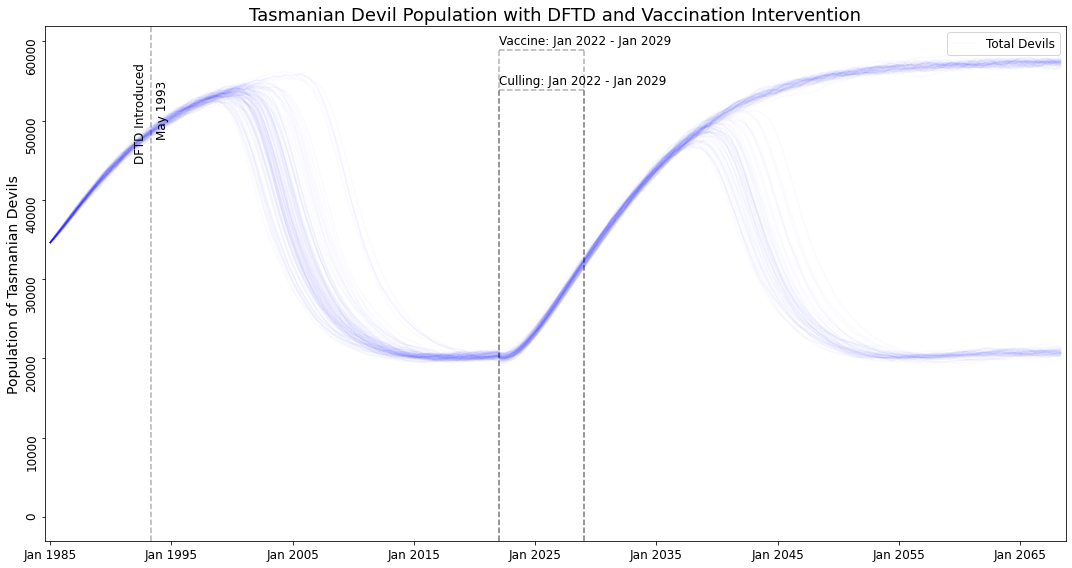

In [19]:
plot_figure_12c(fig_12c_sim, alpha=0.02)

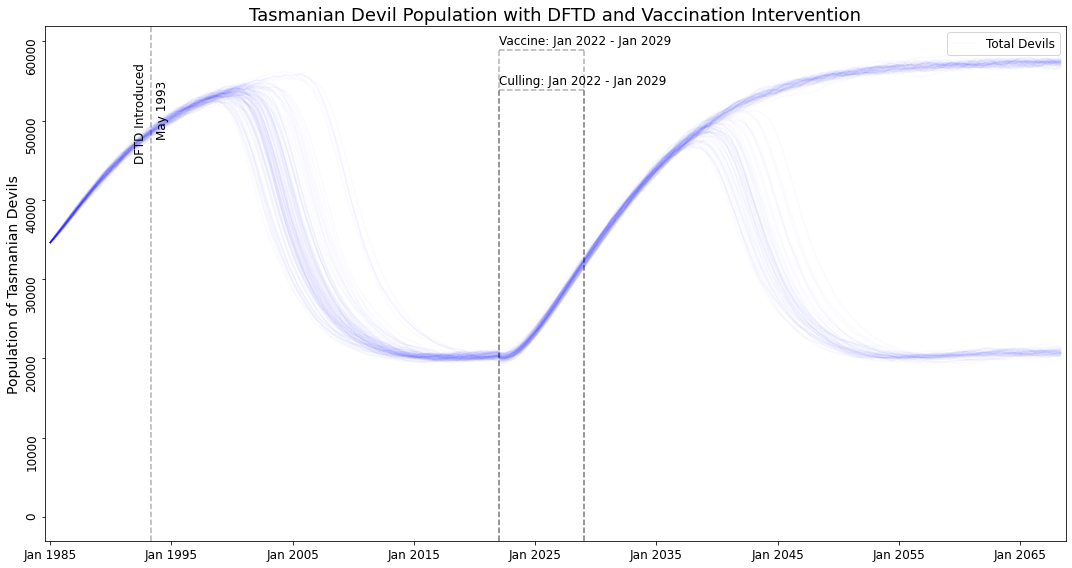

In [20]:
# plot_figure_12c(fig_12c_sim, alpha=0.02, save_fig="figures/DFTDmodel_sec4_vacccull-variable-success.pdf")

In [21]:
c.close()